# Chapter 3 - Classification


## 3.1 MNIST


In [1]:
# Common imports
import numpy as np
import os
import sklearn

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
print(mnist.keys())

c:\Users\hansu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


5


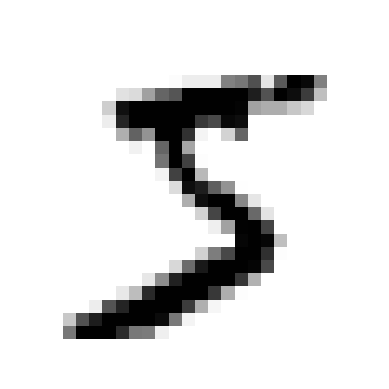

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

y = y.astype(np.uint8)
print(y[0])
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련


전체 숫자를 분류하기 전 5와 5가 아닌 숫자를 판별하는 이진 분류기(Binary Classifier) 만들기


In [6]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
print(sgd_clf.predict([some_digit]))

[ True]


## 3.3 성능 측정

### a. 교차 검증을 사용한 정확도 측정


In [9]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.95035 0.96035 0.9604 ]


In [10]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.91125 0.90855 0.90915]


### b. 오차 행렬


In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]


### 정밀도와 재현율


In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [15]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


### 정밀도/재현율 트레이드오프


In [16]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [17]:
threshold = 0
y_some_digit_pred = y_scores > threshold
print(y_some_digit_pred)

[ True]


In [18]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
print(y_some_digit_pred)

[False]


In [19]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

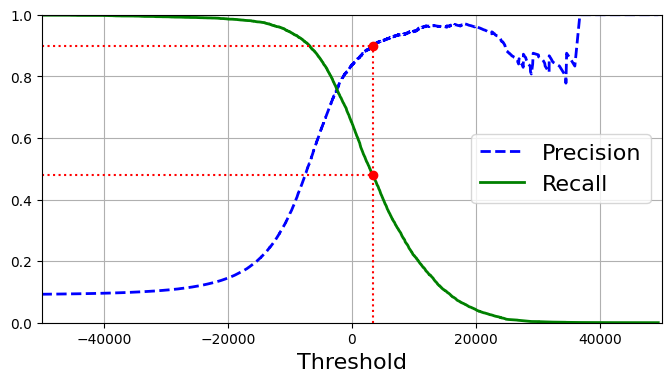

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0.0, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot(
    [-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:"
)
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

In [22]:
(y_train_pred == (y_scores > 0)).all()

True

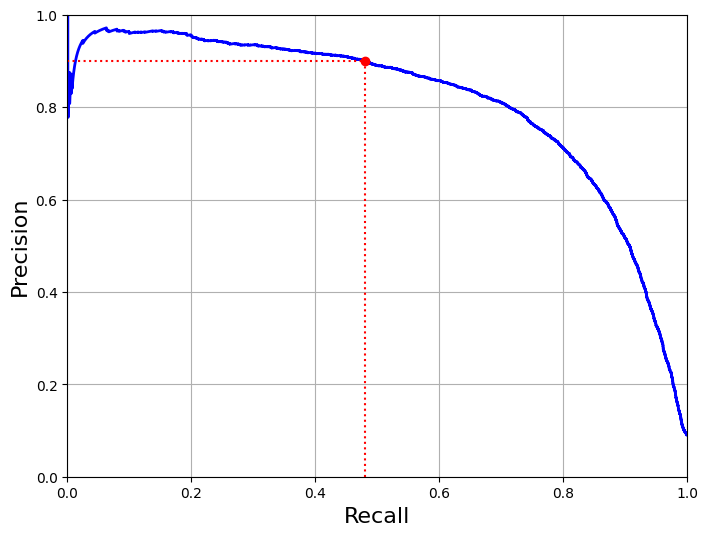

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [24]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [25]:
print(precision_score(y_train_5, y_train_pred_90))

0.9


In [26]:
print(recall_score(y_train_5, y_train_pred_90))

0.47980077476480354


### ROC 곡선

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

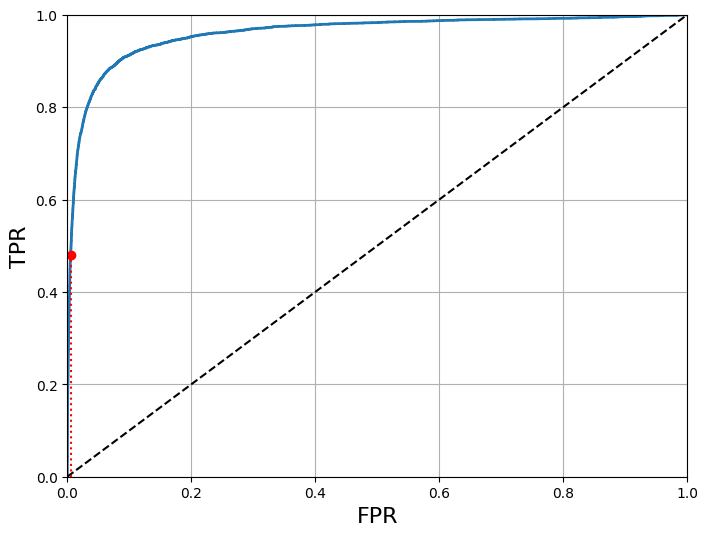

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0.0, recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

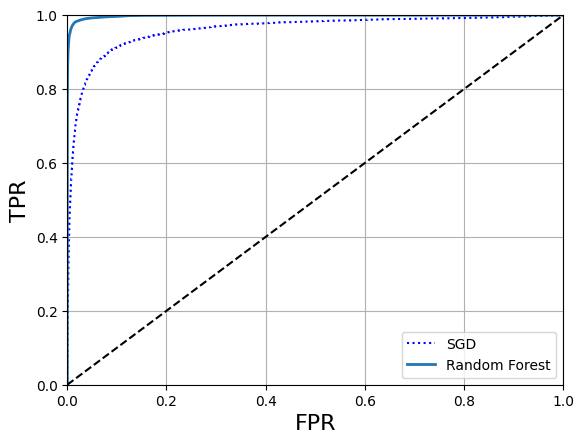

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## 3.4 다중 분류

In [33]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print(svm_clf.predict([some_digit]))

[5]


In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


In [35]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [36]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [38]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


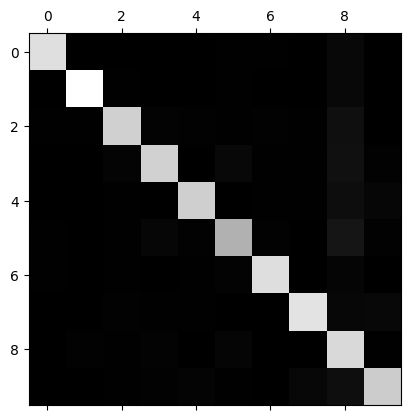

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

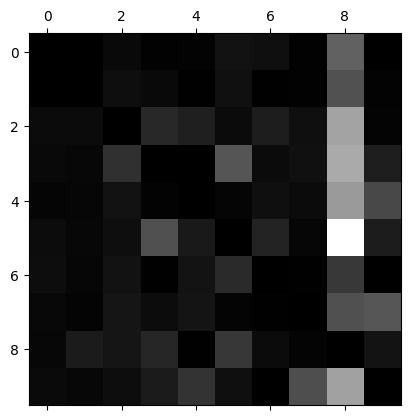

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [49]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

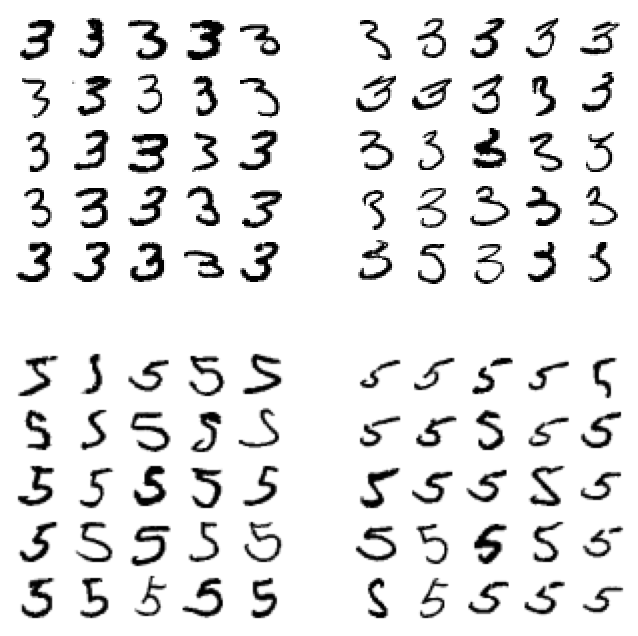

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [53]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


## 3.7 다중 출력 분류

In [58]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

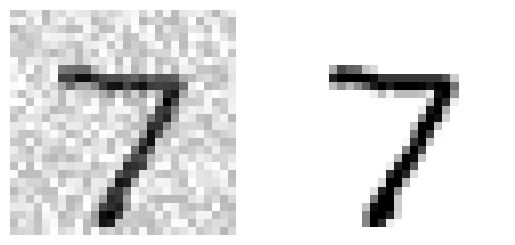

In [61]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

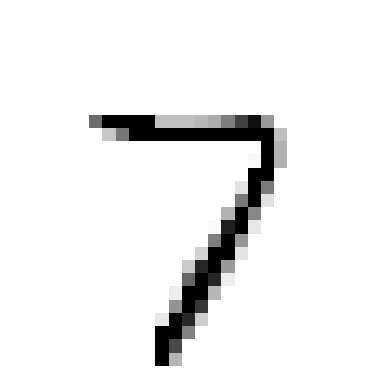

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)